In [1]:
from __future__ import division

from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from math import inf, sqrt
from skimage import data, color
from skimage.transform import rescale, resize

In [2]:
class FastMarching:

    def __init__(self, W, start_point, end_point=None):
        self.n = W.shape[0]
        self.W = W
        self.start_point = start_point
        self.end_point = end_point
        self.neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])
        self.D = None
        self.S = None

    def boundary(self, x):
        return np.mod(x, self.n)

    def ind2sub1(self, k):
        return [int( (k-np.fmod(k,self.n))/self.n ), np.fmod(k,self.n)]

    def sub2ind1(self, u):
        return int(u[0]*self.n + u[1])

    def Neigh(self, k, i):
        neigh_coord = self.boundary(self.ind2sub1(k) + self.neigh[:,i])
        if self.is_border(neigh_coord):
            return None
        else:
            return self.sub2ind1(neigh_coord)

    def is_border(self, pixel_coord):
        return bool(np.sum(pixel_coord==0) + np.sum(pixel_coord==self.n))

    def extract(self, x, I):
        return x[I]

    def extract1d(self, x, I):
        if I is None:
            return inf
        else:
            return self.extract(x.flatten(), I)

    def fast_marching(self, lmbda=5, max_iter=inf, end_point=None):
        
        x0 = [self.start_point[1], self.start_point[0]]
        I = [self.sub2ind1(x0)]

        # Initial distance to x0
        D = np.ones((self.n, self.n)) + inf
        u = self.ind2sub1(I)
        D[u[0], u[1]] = 0

        # To visit or not
        S = np.zeros((self.n, self.n))
        S[u[0], u[1]] = 1

        count = 0
        keypoint_found = False
        endpoint_found = False

        while I and count < max_iter and not keypoint_found and not endpoint_found:

            count += 1
            j = np.argsort(self.extract1d(D, I))
            if np.ndim(j) == 0:
                j = [j]

            j = j[0]
            i = I[j]
            a = I.pop(j)

            u = self.ind2sub1(i)
            S[u[0], u[1]] = -1

            J = []
            for k in np.arange(0, 4):
                v_ = self.Neigh(i, k)
                if v_ is None:
                    continue
                j = v_
                if self.extract1d(S, j) != -1:
                    J.append(j)
                    if self.extract1d(S, j) == 0:
                        # add to the front
                        u = self.ind2sub1(j)
                        S[u[0], u[1]] = 1
                        I.append(j)

            DNeigh = lambda D, k: self.extract1d(D, self.Neigh(j, k))

            for j in J:

                # Update by L1 min
                dx = min(DNeigh(D,0), DNeigh(D,1))
                dy = min(DNeigh(D,2), DNeigh(D,3))
                u = self.ind2sub1(j)
                w = self.extract1d(self.W,j)

                Delta = 2*w - (dx-dy)**2
                if (Delta>=0):
                    D[u[0],u[1]] = (dx + dy + sqrt(Delta))/ 2
                else:
                    D[u[0],u[1]] = min(dx + w, dy + w)
            
            # Stopping criterion for keypoint
            if lmbda < inf:
                # Calcul de la distance euclidienne
                x = np.where(S==1)[0]
                y = np.where(S==1)[1]

                Front = np.array([y, x]).T
                L = np.linalg.norm(Front - np.array(start_point), axis=1)

                keypoint_index = np.argmax(L)
                keypoint = Front[keypoint_index]
                max_euclidian_distance = L[keypoint_index]
                self.keypoint = keypoint

                if max_euclidian_distance > lmbda:
                    keypoint_found = True
            
            if end_point is not None:
                if D[end_point[1], end_point[0]] < inf:
                    endpoint_found = True
                    
        self.D = D
        self.S = S
        

    def visualize_D(self):
        if self.D is not None:
            plt.figure(figsize=(10, 10))
            plt.title('Distance')
            plt.scatter(self.start_point[0], self.start_point[1])
            plt.imshow(self.D, cmap='jet')
            plt.show()

    def visualize_S(self):
        if self.S is not None:
            fig = plt.figure(figsize=(10, 10))
            plt.title('Active and Inactive points')
            plt.scatter(self.start_point[0], self.start_point[1])
            im = plt.imshow(self.S, cmap='jet')
            fig.colorbar(im, orientation='horizontal')
            plt.show()

    def backpropagate(self, end_point, max_iter=300):
        self.end_point = end_point
        
        min_path = [list(self.end_point)]
        count = 0

        while np.prod(min_path[-1]==self.start_point) != 1 and count < max_iter:

            point = min_path[-1]
            neighbors_mat = np.array(list(point)).reshape(2, 1) + self.neigh
            min_distance = np.inf

            for k in range(4):
                coord = neighbors_mat[:, k]
                distance = self.D[coord[1], coord[0]]
                if distance < min_distance:
                    min_distance = distance
                    next_point = coord

            min_path.append(list(next_point))

            count += 1

        self.min_path = np.array(min_path)

    def visualize_min_path(self):

        start_point = self.start_point
        end_point = self.end_point

        plt.figure(figsize=(10, 10))
        plt.title('User specified start and end points:')
        plt.scatter(start_point[0], start_point[1], color='g', edgecolor='k', s=200, marker='^', alpha=0.6, label='Start point')
        plt.scatter(end_point[0], end_point[1], color='r', edgecolor='k', s=200, marker='^', alpha=0.6, label='End point')
        plt.scatter(self.min_path[:, 0], self.min_path[:, 1], color='r', edgecolor='k', alpha=0.3)
        plt.imshow(self.W, cmap='gray')
        plt.legend()
        plt.show()

In [3]:
# Image loader
im = Image.open("image/01_sample")
im_array = np.asarray(im.convert('L'))
im_array = resize(im_array, (100, 100))*256

/home/tdesfont/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
# Initialisation of potential function matrix and starting point

# Potential
W = im_array
n = im_array.shape[0]
# Matrix
x_start = np.where(np.sum(im_array<200, axis=0) != 0)[0][0]
y_start = np.where(np.sum(im_array<200, axis=1) != 0)[0][0]
p = (x_start, y_start)
S = [p]

## Open Curve Detection

In [5]:
# Open Curve Detection using the Fast Marching Module
# Input W, S
StopDetection = False
lmbda = 5

In [6]:
# FMM(S, lmbda)
start_point = S[0]
fm = FastMarching(W, start_point)
fm.fast_marching(lmbda=5)
k1 = tuple(fm.keypoint)

In [7]:
k1

(12, 21)

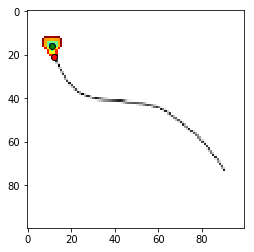

In [8]:
plt.imshow(W, cmap='gray')
plt.imshow(fm.D, cmap='jet')
plt.scatter(start_point[0], start_point[1], edgecolor='k', alpha=1, color='g', label='starting point')
plt.scatter(k1[0], k1[1], edgecolor='k', alpha=1, color='r', label='end point')
plt.show()

In [9]:
fm.backpropagate(k1)

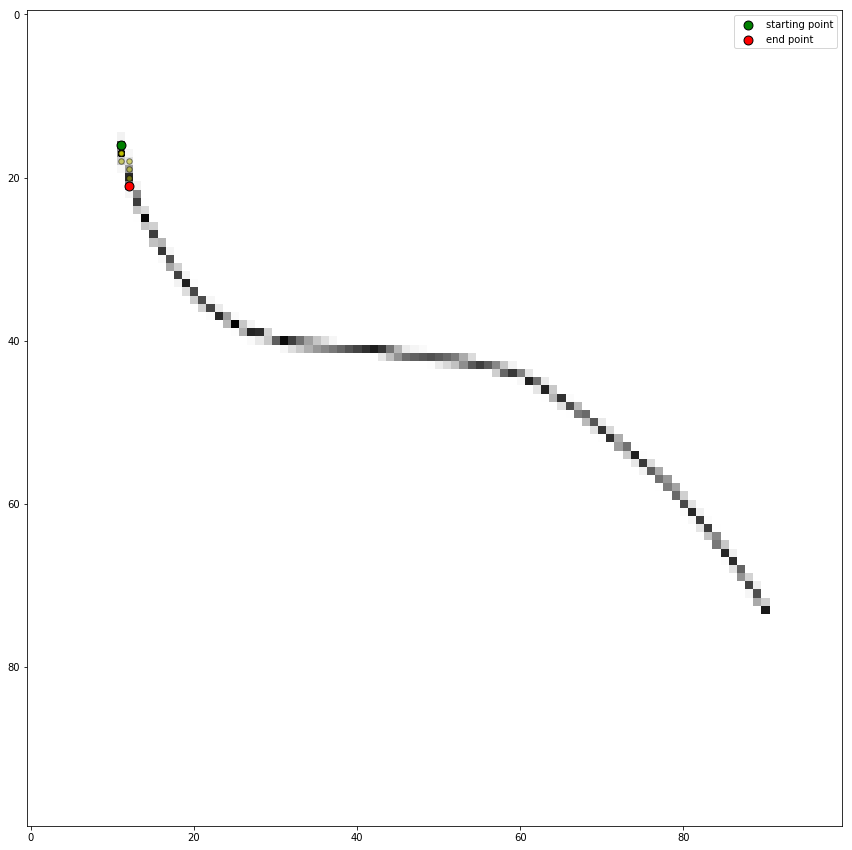

In [10]:
plt.figure(figsize=(15, 15))
plt.imshow(W, cmap='gray')
plt.scatter(fm.min_path[:, 0], fm.min_path[:, 1], edgecolor='k', color='y', alpha=0.5, s=30)
plt.scatter(start_point[0], start_point[1], edgecolor='k', alpha=1, color='g', label='starting point', s=80)
plt.scatter(k1[0], k1[1], edgecolor='k', alpha=1, color='r', label='end point', s=80)
plt.legend()
plt.show()

In [11]:
C = fm.min_path

In [12]:
S.append(k1)
print(S)

[(11, 16), (12, 21)]


In [13]:
m = {}

In [14]:
m[start_point] = k1
m[k1] = start_point

In [15]:
k1

(12, 21)

In [16]:
m

{(11, 16): (12, 21), (12, 21): (11, 16)}

**Find keypoint k2**

In [17]:
S

[(11, 16), (12, 21)]

In [18]:
# FMM(S, lmbda)
start_point = S[1]
fm = FastMarching(W, start_point)
fm.fast_marching(lmbda=5)
k2 = tuple(fm.keypoint)

In [19]:
k2 # Symmétrie

(11, 16)

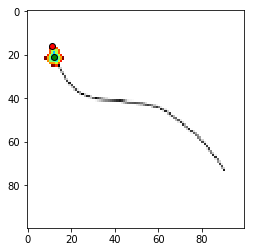

In [20]:
plt.imshow(W, cmap='gray')
plt.imshow(fm.D, cmap='jet')
plt.scatter(start_point[0], start_point[1], edgecolor='k', alpha=1, color='g', label='starting point')
plt.scatter(k2[0], k2[1], edgecolor='k', alpha=1, color='r', label='end point')
plt.show()